<a href="https://colab.research.google.com/github/HarnoorOberai/Image-Classification/blob/master/HarnoorSinghOberai__190753898__GoogleNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import warnings
warnings.filterwarnings('ignore')

from keras.models import Model
from keras.utils import plot_model
from keras import regularizers
from keras import backend as K
from keras.layers import Input,Flatten, Dense,Dropout,BatchNormalization, concatenate
from keras.layers.convolutional import Conv2D,MaxPooling2D,AveragePooling2D

Using TensorFlow backend.


In [0]:
NB_CLASS=10
LEARNING_RATE=0.01
MOMENTUM=0.9
ALPHA=0.0001
BETA=0.75
GAMMA=0.1
DROPOUT=0.4
WEIGHT_DECAY=0.0005
LRN2D_NORM=True
DATA_FORMAT='channels_last' # Theano:'channels_first' Tensorflow:'channels_last'
USE_BN=True
IM_WIDTH=28
IM_HEIGHT=28
EPOCH=50

In [0]:
def conv2D_lrn2d(x,filters,kernel_size,strides=(1,1),padding='same',dilation_rate=(1,1),activation='relu',
                 use_bias=True,kernel_initializer='glorot_uniform',bias_initializer='zeros',
                 kernel_regularizer=None,bias_regularizer=None,activity_regularizer=None,
                 kernel_constraint=None,bias_constraint=None,lrn2d_norm=LRN2D_NORM,weight_decay=WEIGHT_DECAY):
    #l2 normalization
    if weight_decay:
        kernel_regularizer=regularizers.l2(weight_decay)
        bias_regularizer=regularizers.l2(weight_decay)
    else:
        kernel_regularizer=None
        bias_regularizer=None
    x=Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding=padding,dilation_rate=dilation_rate,
             activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,
             bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,
             activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(x)
    if lrn2d_norm:
        #batch normalization
        x=BatchNormalization()(x)

    return x

In [0]:
def inception_module(x,params,concat_axis,padding='same',dilation_rate=(1,1),activation='relu',
                     use_bias=True,kernel_initializer='glorot_uniform',bias_initializer='zeros',
                     kernel_regularizer=None,bias_regularizer=None,activity_regularizer=None,kernel_constraint=None,
                     bias_constraint=None,lrn2d_norm=LRN2D_NORM,weight_decay=None):
    (branch1,branch2,branch3,branch4)=params
    if weight_decay:
        kernel_regularizer=regularizers.l2(weight_decay)
        bias_regularizer=regularizers.l2(weight_decay)
    else:
        kernel_regularizer=None
        bias_regularizer=None
    #1x1
    pathway1=Conv2D(filters=branch1[0],kernel_size=(1,1),strides=1,padding=padding,dilation_rate=dilation_rate,
                    activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,
                    activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(x)
    #1x1->3x3
    pathway2=Conv2D(filters=branch2[0],kernel_size=(1,1),strides=1,padding=padding,dilation_rate=dilation_rate,
                    activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,
                    activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(x)
    pathway2=Conv2D(filters=branch2[1],kernel_size=(3,3),strides=1,padding=padding,dilation_rate=dilation_rate,
                    activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,
                    activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(pathway2)
    #1x1->5x5
    pathway3=Conv2D(filters=branch3[0],kernel_size=(1,1),strides=1,padding=padding,dilation_rate=dilation_rate,
                    activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,
                    activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(x)
    pathway3=Conv2D(filters=branch3[1],kernel_size=(5,5),strides=1,padding=padding,dilation_rate=dilation_rate,
                    activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,
                    activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(pathway3)
    #3x3->1x1
    pathway4=MaxPooling2D(pool_size=(3,3),strides=1,padding=padding,data_format=DATA_FORMAT)(x)
    pathway4=Conv2D(filters=branch4[0],kernel_size=(1,1),strides=1,padding=padding,dilation_rate=dilation_rate,
                    activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer,kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,
                    activity_regularizer=activity_regularizer,kernel_constraint=kernel_constraint,bias_constraint=bias_constraint)(pathway4)

    return concatenate([pathway1,pathway2,pathway3,pathway4],axis=concat_axis)

In [0]:
class GoogleNet:
    @staticmethod
    def build(width, height, depth, NB_CLASS):
        INP_SHAPE = (height, width, depth)
        img_input = Input(shape=INP_SHAPE)
        CONCAT_AXIS = 3
        # Data format:tensorflow,channels_last;theano,channels_last
        if K.image_data_format() == 'channels_first':
            INP_SHAPE = (depth, height, width)
            img_input = Input(shape=INP_SHAPE)
            CONCAT_AXIS = 1
        x = conv2D_lrn2d(img_input, 64, (7, 7), 2, padding='same', lrn2d_norm=False)
        x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(x)
        x = BatchNormalization()(x)

        x = conv2D_lrn2d(x, 64, (1, 1), 1, padding='same', lrn2d_norm=False)

        x = conv2D_lrn2d(x, 192, (3, 3), 1, padding='same', lrn2d_norm=True)
        x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(x)

        x = inception_module(x, params=[(64,), (96, 128), (16, 32), (32,)], concat_axis=CONCAT_AXIS)  # 3a
        x = inception_module(x, params=[(128,), (128, 192), (32, 96), (64,)], concat_axis=CONCAT_AXIS)  # 3b
        x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(x)

        x = inception_module(x, params=[(192,), (96, 208), (16, 48), (64,)], concat_axis=CONCAT_AXIS)  # 4a
        x = inception_module(x, params=[(160,), (112, 224), (24, 64), (64,)], concat_axis=CONCAT_AXIS)  # 4b
        x = inception_module(x, params=[(128,), (128, 256), (24, 64), (64,)], concat_axis=CONCAT_AXIS)  # 4c
        x = inception_module(x, params=[(112,), (144, 288), (32, 64), (64,)], concat_axis=CONCAT_AXIS)  # 4d
        x = inception_module(x, params=[(256,), (160, 320), (32, 128), (128,)], concat_axis=CONCAT_AXIS)  # 4e
        x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(x)

        x = inception_module(x, params=[(256,), (160, 320), (32, 128), (128,)], concat_axis=CONCAT_AXIS)  # 5a
        x = inception_module(x, params=[(384,), (192, 384), (48, 128), (128,)], concat_axis=CONCAT_AXIS)  # 5b
        x = AveragePooling2D(pool_size=(1, 1), strides=1, padding='valid')(x)

        x = Flatten()(x)
        x = Dropout(DROPOUT)(x)
        x = Dense(output_dim=NB_CLASS, activation='linear')(x)
        x = Dense(output_dim=NB_CLASS, activation='softmax')(x)

        # Create a Keras Model
        model = Model(input=img_input, output=[x])
        model.summary()
        # Save a PNG of the Model Build
        # plot_model(model, to_file='../imgs/GoogLeNet.png')
        # return the constructed network architecture
        return model

In [0]:
import numpy as np
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K
from keras.models import load_model

In [0]:
# load minit data
from keras.datasets import mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()


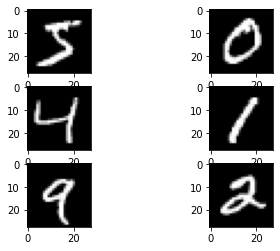

In [8]:
# plot 6 images as gray scale
import matplotlib.pyplot as plt

plt.subplot(321)
plt.imshow(x_train[0],cmap=plt.get_cmap('gray'))
plt.subplot(322)
plt.imshow(x_train[1],cmap=plt.get_cmap('gray'))
plt.subplot(323)
plt.imshow(x_train[2],cmap=plt.get_cmap('gray'))
plt.subplot(324)
plt.imshow(x_train[3],cmap=plt.get_cmap('gray'))
plt.subplot(325)
plt.imshow(x_train[4],cmap=plt.get_cmap('gray'))
plt.subplot(326)
plt.imshow(x_train[5],cmap=plt.get_cmap('gray'))
# show
plt.show()

In [9]:
print(x_train.shape)
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')

# normalization
x_train = x_train / 255.0
x_test = x_test / 255.0

# one-hot
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

(60000, 28, 28)


In [0]:
# parameters
EPOCHS = 50
INIT_LR = 1e-3
BS = 32
CLASS_NUM = 10
norm_size = 28


In [11]:
# start to train model
print('start to train model')

model = GoogleNet.build(width=norm_size, height=norm_size, depth=1, NB_CLASS=CLASS_NUM)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])


# Use generators to save memory
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                             horizontal_flip=True, fill_mode="nearest")

H = model.fit_generator(aug.flow(x_train, y_train, batch_size=BS),
                            steps_per_epoch=len(x_train) // BS, validation_data=aug.flow(x_test, y_test),
                            epochs=EPOCHS, verbose=2, use_multiprocessing=False)


start to train model
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 7, 7, 64)     0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 7, 7, 64)     256         max_pooling2d_1[0][0]            
_______________________________________________________________________

In [0]:

# save model
# method one
model.save('googlenet.h5')

# method two
# save model by json and weights
# save json
from keras.models import model_from_json
json_string = model.to_json()
with open(r'googlenet.json', 'w') as file:
    file.write(json_string)

# save weights
model.save_weights('googlenet.h5')


In [0]:
import json
# Get the dictionary containing each metric and the loss for each epoch
GoogleNet_mnist_history_dict = H.history
# Save it under the form of a json file
json = json.dumps(str(GoogleNet_mnist_history_dict))
f = open("GoogleNet_mnist_history_dict.json","w")
f.write(json)
f.close()

In [0]:
import json 
data = {}
# Opening JSON file 
with open("GoogleNet_mnist_history_dict.json") as json_file: 
    data = json.load(json_file)

In [17]:
print(type(data))
result_dict = eval(data)
print(result_dict.keys())

<class 'str'>
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


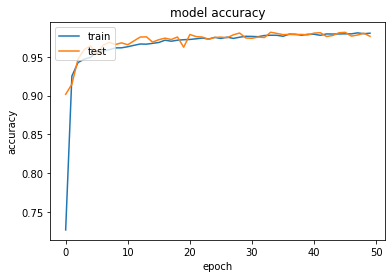

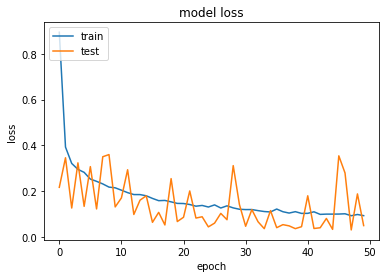

In [18]:
plt.plot(result_dict['accuracy'])
plt.plot(result_dict['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(result_dict['loss'])
plt.plot(result_dict['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

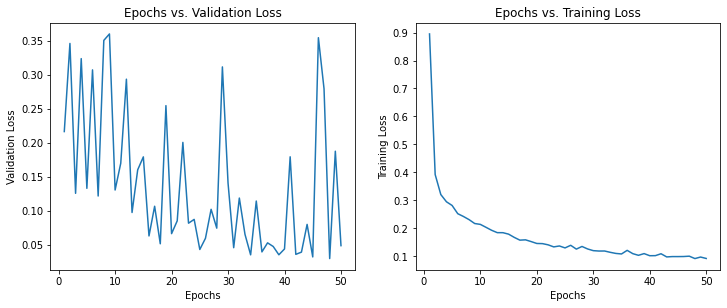

In [19]:
nb_epoch = EPOCHS

fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,nb_epoch+1), result_dict['val_loss'])
ax1.set(xlabel='Epochs', ylabel='Validation Loss',
       title='Epochs vs. Validation Loss')
ax2.plot(np.arange(1,nb_epoch+1), result_dict['loss'])
ax2.set(xlabel='Epochs', ylabel='Training Loss',
       title='Epochs vs. Training Loss')
plt.show()

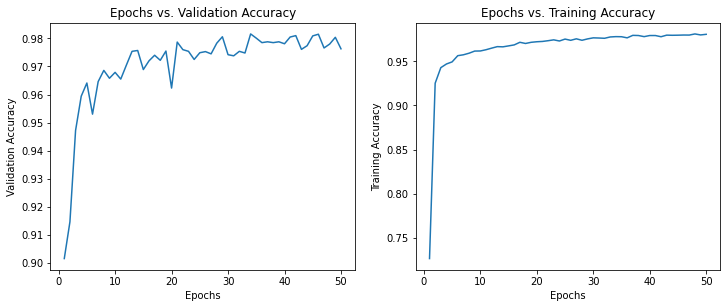

In [20]:

fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,nb_epoch+1), result_dict['val_accuracy'])
ax1.set(xlabel='Epochs', ylabel='Validation Accuracy',
       title='Epochs vs. Validation Accuracy')
ax2.plot(np.arange(1,nb_epoch+1), result_dict['accuracy'])
ax2.set(xlabel='Epochs', ylabel='Training Accuracy',
       title='Epochs vs. Training Accuracy')
plt.show()

In [0]:
# import tensorflow as tf

In [0]:
predictions = model.predict(x_test, verbose=0)

In [55]:
np.argmax(y_test[0])

7

In [0]:
def test_accuracy():
    err = []
    t = 0
    for i in range(predictions.shape[0]):
        if np.argmax(predictions[i]) == np.argmax(y_test[i]):
            t = t+1
        else:
            err.append(i)
    return t, float(t)*100/predictions.shape[0], err

In [66]:
p = test_accuracy()
print(p[1])
print("Test accuracy: {} %".format(p))

98.05
Test accuracy: (9805, 98.05, [8, 62, 158, 193, 221, 247, 292, 318, 324, 333, 394, 397, 409, 445, 449, 469, 536, 582, 617, 618, 625, 629, 653, 716, 797, 882, 883, 936, 938, 1017, 1032, 1087, 1112, 1114, 1124, 1178, 1202, 1226, 1232, 1247, 1290, 1299, 1331, 1339, 1352, 1393, 1414, 1438, 1508, 1670, 1681, 1691, 1737, 1748, 1773, 1790, 1811, 1866, 1895, 1901, 1903, 1924, 1940, 1941, 1948, 2035, 2040, 2130, 2276, 2308, 2326, 2395, 2447, 2454, 2462, 2513, 2526, 2533, 2534, 2559, 2573, 2582, 2597, 2616, 2720, 2771, 2780, 2787, 2927, 2939, 2956, 3005, 3048, 3073, 3134, 3225, 3330, 3343, 3361, 3365, 3412, 3422, 3475, 3534, 3537, 3558, 3682, 3727, 3767, 3871, 3913, 3968, 4163, 4201, 4284, 4369, 4443, 4482, 4506, 4507, 4547, 4569, 4608, 4656, 4736, 4761, 4823, 4860, 4878, 4990, 5308, 5654, 6391, 6392, 6538, 6543, 6544, 6554, 6571, 6576, 6584, 6607, 6625, 6629, 6755, 6783, 6880, 7426, 7530, 7545, 7574, 7627, 7910, 8000, 8065, 8276, 8279, 8316, 8322, 8323, 8374, 8382, 8408, 8522, 8527, 9009, 

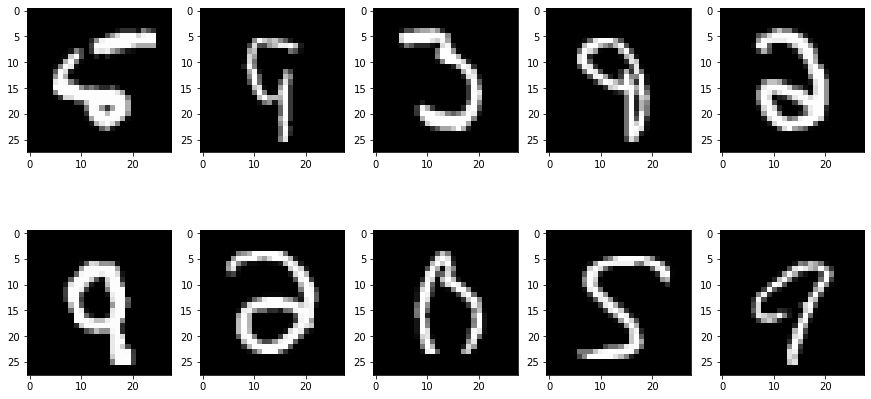

True classification as: [6 7 6 8 6]
True classification as: [8 6 7 2 7]


In [63]:
fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(x_test[p[2][i]].reshape(28,28), interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(x_test[p[2][i+6]].reshape(28,28), interpolation='none', cmap=plt.cm.gray)
plt.show()

# print("True:          {}".format(y_test[p[2][0:5]]))
print("True classification as: {}".format(np.argmax(predictions[p[2][0:5]], axis=1)))

# print("True:          {}".format(y_test[p[2][6:11]]))
print("True classification as: {}".format(np.argmax(predictions[p[2][6:11]], axis=1)))